# Projet TAL M1 S1 : POS Tagging

# Implémentation du classifieur

## Import du corpus

On charge les trois corpus *in-domain* sous la forme de listes de dictionnaires : chaque phrase a une clé "mots" qui est associée à une liste des mots, et une clé "POS" associée à une liste de POS. 

On utilise les trois corpus distincts de French-GSD :
- Train : apprentissage.
- Dev : validation. Pour tester et améliorer le modèle. 
- Test : évaluation. On ne l'utilisera pas pendant l'apprentissage ou les tests.

In [1]:
def load_corpus(file):
    with open(file, "r", encoding = "utf8") as f: 
        content = f.read() # chargement du corpus
    content = content.split("\n\n") # séparation en phrases
    corpus = []
    for phrase in content: # pour chaque phrase
        phrase_dico = {"mots" : [], "gold_labels" : []} # liste qui contiendra 1 dictionnaire par mot de la phrase
        for line in phrase.splitlines():
            if not line.startswith("#"): # on ignore les lignes qui commencent par #
                features = line.split("\t")
                phrase_dico["mots"].append(features[1])
                # phrase_dico["lemme"].append(features[2])
                phrase_dico["gold_labels"].append(features[3])
        corpus.append(phrase_dico)
    return corpus

gsd_train = load_corpus("corpus-in-domain/fr_gsd-ud-train.conllu")
gsd_test = load_corpus("corpus-in-domain/fr_gsd-ud-test.conllu")
gsd_dev = load_corpus("corpus-in-domain/fr_gsd-ud-dev.conllu")

In [2]:
print("---- Aperçus d'une phrase de chaque corpus-----", end="\n\n")
print(gsd_train[1], end="\n\n")
print(gsd_test[102], end="\n\n")
print(gsd_dev[564])

---- Aperçus d'une phrase de chaque corpus-----

{'mots': ["L'", 'œuvre', 'est', 'située', 'dans', 'la', 'galerie', 'des', 'de', 'les', 'batailles', ',', 'dans', 'le', 'château', 'de', 'Versailles', '.'], 'gold_labels': ['DET', 'NOUN', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN', 'PUNCT', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT']}

{'mots': ['La', 'gestion', 'et', "l'", 'exploitation', 'de', 'la', 'salle', 'de', 'concert', 'Wagram', ',', 'récemment', 'rénovée', ',', 'sera', 'assurée', 'par', 'Eurosites', ',', 'leader', 'en', 'France', 'de', 'la', 'location', 'de', 'salles', '.'], 'gold_labels': ['DET', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PROPN', 'PUNCT', 'ADV', 'VERB', 'PUNCT', 'AUX', 'VERB', 'ADP', 'PROPN', 'PUNCT', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT']}

{'mots': ['Cette', 'espèce', 'est', 'endémique', 'du', 'de', 'le', 'département', 'de', 'Nariño', 'en', 'Colombie', '.'], 'gold_labels': ['DET'

## Extraction des caractéristiques

La fonction feature_extraction renvoie une liste de dictionnaires (un par mot) qui contiennent les caractéristiques suivantes pour chaque mot :
- mot
- mot précédent : pour le premier mot de la phrase son mot précédent sera "START", ce qui permettra de prendre en compte la caractéristique "être le premier mot".
- mot suivant : pour le dernier mot, ce sera "END".
- commence par une lettre majuscule
- est entièrement en majuscules
- contient des chiffres
- contient des caractères non alphanumériques
- longueur du mot (3 caractéristiques binaires) : a 1 seule caractère, a au plus 3 caractères, a plus de 3 caractères.   
- a un suffixe nominal
- a un suffixe adjectival
- a un suffixe verbal
- a un suffixe adverbial

On ne conserve plus la structure des phrases, qui n'est plus nécessaire une fois qu'on a extrait les informations comme mot précédent et mot suivant.

Ces caractéristiques sont encodées sous la forme d'un dictionnaire pour chaque mot dont les clés désignent les caractéristiques ("mot - commotions", "prec - les", "long", "suff_nom", etc. ) et les valeurs valent 1 quand la caractéristique est vraie pour ce mot. Si la caractéristique n'est pas vraie, alors on n'ajoute pas cette entrée dans le dictionnaire, ce qui permettrait d'optimiser l'apprentissage et la prédiction ensuite.

On a ajouté des booléens pour les différentes catégorie de caractéristiques (mots, majuscules, longueur, caractères non alphabétique et suffixes) qui sont pas défaut True et qu'on utilisera plus tard pour tester l'utilité de ces caractéristiques.

In [3]:
def feature_extraction(corpus, feat_mots=True, feat_maj=True, feat_non_alpha=True, feat_long=True, feat_suff=True):

    corpus_features = []

    list_vb = ["iser","ifier", "oyer","ailler", "asser","eler", "eter","iller", "iner","nicher", "ocher","onner","otter","oter", "ouiller"]
    list_adj = ["ain", "aine","ains", "aines","aire", "aires","é", "ée","ées", "és","iel", "iels","uel", "uels", 
"lle", "lles","els", "el" "al", "ales", "al", "ial", "aux","iaux", "er","ers", "ère","ères", "ier", "iers",      "esque","esques", "eur","eurs", "euse","euses", "ieux","ueux", "if", "ifs","ive", "ives","in", "ins","ine",      "ines","iques", "ique","atoire", "u","ue", "us","ues", "issime","issimes","able","ible", "ibles","ables",  
    "uble","ubles", "ième","ièmes", "uple"]
    list_noun = ["ade", "ades", "age", "ages","aille", "ailles", "aison", "ison", "isons","oison", "ation", "itions", "ition", "ssion", "sion","xion", "isation","ment", "ement","erie", "eries","ure","ures","ature", "atures","at", "ance","ence", "escence","ité", "eté","té", "ie","erie", "esse", "ise", "eur","isme", "iste", "istes","eurs", "seur","seurs", "isseur","isseurs", "isateur","euse", "euses","isseuse", "isseuses",       "atrice", "atrices","ier", "iers","ière", "ières","aire","aires","ien", "iens","ienne", "iennes","iste",         "istes","er", "ers","eron", "erons","eronne","trice","oir", "oire","oires", "oirs","ier", "iers","ière",         "ières","erie","eries","anderie","aire", "aires","ain", "aines", "ée","ées","aille", "ard","asse", "asses", "assier","âtre","aut","eau", "eaux","ceau", "ereau","eteau", "elle","elles", "et","elet","ets","ette","elette","ettes", "elettes","in", "ins","otin", "ine","ines", "illon","on","ons","ille", "erole","eroles", "ole","oles", "iche"]

    for phrase in corpus: # ajout des features additionnelles
        for prev, word, suiv in zip(["START"] + phrase["mots"][:-1], phrase["mots"], phrase["mots"][1:] + ["END"]):
            # création de triplets (mot précédent, mot, mot suivant)
            # avec "START" en prev pour le 1er mot
            # et "END" en suiv pour le dernier

            # dictionnaire de features du mot
            if feat_mots :
                features_mot = { 
                    # on récupère le gold_label correspondant
                    f"mot - {word.lower()}" : 1,
                    f"prec - {prev.lower()}" : 1,
                    f"mot_suiv - {suiv.lower()}" : 1,
                    }
            else:
                features_mot = {}
            
            if feat_maj:
                if word.istitle(): features_mot["maj"] = 1 
                if word.isupper(): features_mot["all_caps"] = 1

            if feat_non_alpha:
                if any(char.isdigit() for char in word): features_mot["num"] = 1 # mieux que isnumeric(), car renvoie false si espace (40 000) ou virgule (50,6) par ex
                if not word.isalnum(): features_mot["nonAlphanum"] = 1

            if feat_long:
                if len(word) <= 3: features_mot["court"] = 1 
                if len(word) > 3: features_mot["long"] = 1
                if len(word) == 1: features_mot["un_car"] = 1
            
            if feat_suff:
                if word.endswith("ment"): features_mot["suff_adv"] = 1
                if any(word.endswith(elem) and len(word) != len(elem) for elem in list_noun): features_mot["suff_noun"] =1 
                if any(word.endswith(elem) and len(word) != len(elem) for elem in list_adj): features_mot["suff_adj"] = 1
                if any(word.endswith(elem) for elem in list_vb): features_mot["suff_vb"] = 1
                # on vérifie la longueur du mot pour être sûr que ce soit un suffixe car on peut avoir le mot                      age avec le suffixe age par exemple ou bien aux
            
            # ajout au corpus
            corpus_features.append(features_mot)

    return corpus_features # renvoie les features transformés en vecteurs one-hot


In [4]:
gsd_train_features = feature_extraction(gsd_train)

print(len(gsd_train_features))
print(*gsd_train_features[10:15], sep="\n")

364349
{"mot - qu'": 1, 'prec - sport': 1, 'mot_suiv - on': 1, 'nonAlphanum': 1, 'court': 1}
{'mot - on': 1, "prec - qu'": 1, 'mot_suiv - les': 1, 'court': 1}
{'mot - les': 1, 'prec - on': 1, 'mot_suiv - considére': 1, 'court': 1}
{'mot - considére': 1, 'prec - les': 1, 'mot_suiv - presque': 1, 'long': 1}
{'mot - presque': 1, 'prec - considére': 1, 'mot_suiv - comme': 1, 'long': 1, 'suff_adj': 1}


In [5]:
def add_gold(features, corpus, addMot=False):
    '''Ajoute les gold labels pour créer un corpus d'entraînement / de test'''
    i = 0
    gold_corpus = []
    for phrase in corpus:
        for word, pos_gold in zip(phrase["mots"],phrase["gold_labels"]):
            if not pos_gold == "_": # on ignore les mots sans gold_labels
                if addMot:
                    gold_corpus.append((features[i], pos_gold, word))
                else:
                    gold_corpus.append((features[i], pos_gold))
            i += 1

    return gold_corpus

In [6]:
gsd_train_features_gold = add_gold(gsd_train_features, gsd_train)
print(*gsd_train_features_gold[100:110], sep="\n")

({'mot - !': 1, 'prec - plaisir': 1, 'mot_suiv - end': 1, 'nonAlphanum': 1, 'court': 1, 'un_car': 1}, 'PUNCT')
({'mot - les': 1, 'prec - start': 1, 'mot_suiv - forfaits': 1, 'maj': 1, 'court': 1}, 'DET')
({'mot - forfaits': 1, 'prec - les': 1, 'mot_suiv - comprennent': 1, 'long': 1}, 'NOUN')
({'mot - comprennent': 1, 'prec - forfaits': 1, 'mot_suiv - le': 1, 'long': 1}, 'VERB')
({'mot - le': 1, 'prec - comprennent': 1, 'mot_suiv - transport': 1, 'court': 1}, 'DET')
({'mot - transport': 1, 'prec - le': 1, 'mot_suiv - en': 1, 'long': 1}, 'NOUN')
({'mot - en': 1, 'prec - transport': 1, 'mot_suiv - car': 1, 'court': 1}, 'ADP')
({'mot - car': 1, 'prec - en': 1, 'mot_suiv - grand': 1, 'court': 1}, 'NOUN')
({'mot - grand': 1, 'prec - car': 1, 'mot_suiv - tourisme': 1, 'maj': 1, 'long': 1}, 'ADJ')
({'mot - tourisme': 1, 'prec - grand': 1, 'mot_suiv - des': 1, 'maj': 1, 'long': 1, 'suff_noun': 1}, 'NOUN')


## Implémentation de l'algorithme de classification
On a choisi d'implémenter la classification avec un perceptron moyenné.

La fonction predict sera utilisée à la fois dans l'apprentissage et dans la "prédiction". Elle correspond à la recherche de l'étiquette avec le plus grand score (argmax...)

In [7]:
def predict(word_features, weights):
    """Renvoie l'étiquette avec le plus gros score (argmax)"""
    scores = {}
    for tag, w in weights.items():
        scores[tag] =  sum(word_features[feat]*w[feat] for feat in word_features)
    return max(scores, key=scores.get)

In [8]:
from random import shuffle
from collections import defaultdict 

def perceptron_train(training_set, MAX_EPOCH=3):
    
    tags = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]

    # initialisation de a (poids totaux)
    a = defaultdict(lambda: defaultdict(int)) # source : https://stackoverflow.com/questions/5029934/defaultdict-of-defaultdict

    # initialisation des vecteurs de poids
    w = {}
    for tag in tags:
        w[tag] = defaultdict(int)

    n_update = 0 # nombre de mots sur lequel l'entraînement a été effectué

    last_update = defaultdict(lambda: defaultdict(int))  # dictionnaire de dictionnaire suivant la même structure que les vecteurs de poids a et w
    # et qui stocke la valeur de n lors de la dernière modification d'un poid
    
    for i in range(0, MAX_EPOCH):
        shuffled_set = training_set.copy() # copie du training set
        shuffle(shuffled_set) # mélange du training set

        for x in shuffled_set:
            n_update += 1 # on compte le nb de mots déjà vus

            vec = x[0]
            gold = x[1]

            prediction = predict(vec, w) # trouve étiquette plus probable avec les poids w

            if not prediction == gold: # si le gold_label n'est pas égal à celui prédit

                for feat in vec: # pour chaque feature du mot

                    # on met à jour a : ajout de l'ancienne valeur dans w * le nombre de fois où elle n'a pas été modifiée
                    a[gold][feat] += w[gold][feat]*(n_update-last_update[gold][feat])
                    a[prediction][feat] += w[prediction][feat]*(n_update-last_update[prediction][feat])
                     # on modifie le dernier update de l'élément du vecteur
                    last_update[gold][feat] = n_update
                    last_update[prediction][feat] = n_update

                    # on modifie les poids de w pour les 2 étiquettes concernées
                    w[gold][feat] += 1 #  on ajoute x_i à chaque poids de l'étiquette correcte
                    w[prediction][feat] -= 1 #  on retire x_i à chaque poids de l'étiquette mal prédite
                   

    # mise à jour finale tous les poids qui n'ont pas été modifiés lors de la dernière update
    for tag in a:
        for feat in a[tag]:
            a[tag][feat] += w[tag][feat]*(n_update - last_update[tag][feat])

    return a

Pour éviter de mettre entièrement à jour a après chaque mot, puisque la grande majorité des poids reste inchangé, on stocke après chaque modification d'un poids l'index de sa dernière modification, ce qui permet de mettre à jour dans a seulement les vecteurs qui sont modifiés, en ajoutant dans a le poids correspondant dans w, multiplié par le nombre d'update pendant lesquels il n'a pas été modifié.

A la fin de l'apprentissage, on met également à jour tous les poids qui sont "en attente" de mise à jour, c'est-à-dire ceux dont la dernière mise à jour est inférieure à n_update.

In [9]:
# poids_gsd_train = perceptron_train(gsd_train_features_gold)

# Evaluation des performances sur le corpus de validation (Dev)
La fonction test() renvoie le taux d'erreur sur un corpus en utilisant la fonction predict() avec les poids issus de l'apprentissage. On effectue ce test sur le corpus dev avec différents nombres d'itération à l'apprentissage pour voir l'impact des itérations sur ce taux d'erreur.

In [10]:
gsd_dev_features = feature_extraction(gsd_dev)
gsd_dev_features_gold = add_gold(gsd_dev_features, gsd_dev)


def test(corpus, poids):
    """Prédit les étiquettes et renvoie un taux d'erreur"""
    nb_erreurs = 0
    for word in corpus:
        vec = word[0]
        gold = word[1]
        prediction = predict(vec, poids)
        if not gold == "_" and not prediction == gold:
            nb_erreurs +=1

    return nb_erreurs/len(corpus)

In [11]:
from time import time

taux = []
x_range = range(1, 6)

for i in x_range:
    t0 = time()
    poids_gsd_train = perceptron_train(gsd_train_features_gold, MAX_EPOCH=i)
    tx_erreur = test(gsd_dev_features_gold, poids_gsd_train)
    taux.append(tx_erreur)
    print(f"{i} epochs : {tx_erreur:.2%} d'erreurs - temps training + test : {time()-t0:.2f}s")

1 epochs : 4.84% d'erreurs - temps training + test : 12.44s
2 epochs : 4.27% d'erreurs - temps training + test : 23.80s
3 epochs : 4.07% d'erreurs - temps training + test : 33.80s
4 epochs : 3.88% d'erreurs - temps training + test : 44.38s
5 epochs : 3.85% d'erreurs - temps training + test : 54.44s


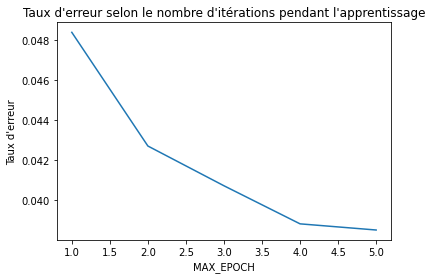

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x_range,taux)
plt.ylabel("Taux d'erreur")
plt.xlabel("MAX_EPOCH")
plt.title("Taux d'erreur selon le nombre d'itérations pendant l'apprentissage")
plt.show()

On remarque qu'à partir d'un seul passage sur le corpus, on descend en dessous de 5% d'erreurs, et qu'à 3 itérations on est environ à 4%. Des itérations additionnelles n'améliorent pas beaucoup ce taux, en tout cas pas assez par rapport au temps additionnel que demande l'entraînement avec ces itérations additionnelles. Nous choisissons donc 3 itérations par défaut.

### Evaluation des caractéristiques
On peut se demander si l'on pourrait obtenir des taux similaires avec moins de features, si certaines features apportent plus de précision que d'autre. Pour cela on réeffectue un apprentissage avec 3 itérations, sans modifier l'extraction de caractéristiques. Puis on teste différentes combinaisons d'extractions de features sur le corpus dev avant d'effectuer le test : seulement les mots (mot, mot précédent et mot suivant), et tout sauf les mots. On pourrait bien sûr tester bien d'autres combinaisons. Les features non extraites sur le corpus dev valent donc toutes zéro pour ce corpus et ne seront pas prises en compte.

In [13]:
poids_gsd_train = perceptron_train(gsd_train_features_gold) # entraînement avec nombre d'itérations par défaut

In [14]:
def test_features(corpus, poids, test_mots=False, test_maj=False, test_non_alpha=False, test_long=False, test_suff=False):
    '''Effectue les 3 étapes nécessaires pour effectuer le test'''
    features = feature_extraction(corpus, feat_mots=test_mots, feat_maj=test_maj, feat_non_alpha=test_non_alpha, feat_long=test_long, feat_suff=test_suff)
    features_gold = add_gold(features, corpus)
    tx_erreur = test(features_gold, poids)
    
    return tx_erreur

print(f"Test avec seulement les mots : {test_features(gsd_train, poids_gsd_train, test_mots=True):.3%}")
print(f"Test avec tout sauf les mots : {test_features(gsd_train, poids_gsd_train, test_maj=True, test_suff=True, test_non_alpha=True, test_long=True):.3%}")

Test avec seulement les mots : 10.351%
Test avec tout sauf les mots : 73.419%


On remarque que sans la prise en compte des mots le résultat est catastrophique ! Testons quelques combinaisons de mots + autres caractéristiques :

In [15]:
print(f"Test avec mots + longueur : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_long=True):.3%}")
print(f"Test avec mots + maj : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_maj=True):.3%}")
print(f"Test avec mots + caractères non alphanumériques : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_non_alpha=True):.3%}")
print(f"Test avec mots + suffixes : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_suff=True):.3%}")

Test avec mots + longueur : 10.411%
Test avec mots + maj : 5.974%
Test avec mots + caractères non alphanumériques : 8.733%
Test avec mots + suffixes : 9.869%


A partir de ces tests non exhaustifs, il semblerait que la prise en compte des majuscules, en plus des mots, apporte davantage de précision que celle d'autres caractéristiques qui pourrait peut-être être éliminée.

### Erreurs fréquentes
On peut analyser les erreurs les plus fréquentes à l'aide d'une matrice de confusion.

In [24]:
# matrice de confusion avec Pandas. source : https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

import pandas as pd

def matrice_confusion(corpus_feat, poids):
    predictions = []
    gold = []

    for word in corpus_feat:
        pred = predict(word[0], poids)
        predictions.append(pred)
        gold.append(word[1])
        if pred == 'NOUN' and word[1] == 'PROPN':
            with open('filename.txt', 'a', encoding="utf-8") as f:
               print(f"NOUN au lieu de PROPN : {word[0]} | journal PROPN : {poids_gsd_train['PROPN']['journal']} | maj PROPN: {poids_gsd_train['PROPN']['maj']} | le PROPN: {poids_gsd_train['PROPN']['prec - le']}",file = f)
               print(f"NOUN au lieu de PROPN : {word[0]} | journal NOUN : {poids_gsd_train['NOUN']['journal']}  | maj NOUN: {poids_gsd_train['NOUN']['maj']} | le NOUN: {poids_gsd_train['NOUN']['prec - le']}",file = f)
              
                
    preds = pd.Series((item for item in predictions), name = "Prédictions")
    refs = pd.Series((item for item in gold), name = "Références")
    matrice_confusion = pd.crosstab(refs, preds, margins=True)
    print(matrice_confusion)

matrice_confusion(gsd_dev_features_gold, poids_gsd_train)

Prédictions   ADJ   ADP   ADV   AUX  CCONJ   DET  INTJ  NOUN  NUM  PART  PRON  \
Références                                                                      
ADJ          1884     0     5     0      0     4     0   114    6     0     6   
ADP             0  5722     0     2      0    13     0     0    0     0     0   
ADV             8     4  1252     3      2     0     0     6    0     0     2   
AUX             0     0     1  1082      0     0     0     5    0     0     0   
CCONJ           0     0     2     1    881     0     0     0    0     0     0   
DET             7    19     0     0      0  5481     0     0    2     0     5   
INTJ            0     0     0     0      0     0     2     0    0     0     1   
NOUN           56     1     8     5      1     1     1  6392    4     0     1   
NUM             0     0     0     0      0     3     0     4  938     0     3   
PART            0     0     1     0      0     0     0     0    0     6     0   
PRON            8     9     

Les erreurs les plus fréquentes sont (> 30 en moyenne):
- ADJ au lieu de VERB
- ADJ au lieu de NOUN
- ADJ au lieu de PROPN 
- AUX au lieu de VERB
- PRON au lieu de DET
- NOUN au lieu d'ADJ
- NOUN au lieu de PROPN
- NOUN au lieu de VERB
- PROPN au lieu d'ADJ
- PROPN au lieu de NOUN
- PROPN au lieu de X
- VERB au lieu d'ADJ
- VERB au lieu d'AUX
- VERB au lieu de NOUN

Nous pouvons voir que celles qui reviennent le plus souvent sont les confusions ADJ - NOUN - VERB. En ce qui concerne la confusion entre ces trois catégories, cela est explicable par l'homonymie de suffixes, comme -er qui est autant un suffixe nominal qu'adjectival. Il peut donc parfois être difficile de distinguer un participe présent d'un NOUN ou encore d'un ADJ. Par exemple, "présente" ou "faisant" selon le contexte restent ambigus. 

En ce qui concerne la confusion AUX - VERB, cela s'explique tout simplement par le fait qu'un AUX est aussi un VERB. Nous pouvons juste citer "aurais" ou "faire" pour illustrer ce fait.

Lorsque nous nous intéressons à la confusion PRON - DET, nous pouvons voir que les PRON qui ressortent le plus souvent sont principalement "le" et "la". 

Là ou cela est plus difficilement explicable, est la confusion avec les PROPN. En effet, nous pourrions penser que le simple fait de dire qu'il y a une majuscule en début de mot fait de celui-ci un PROPN mais cela se révèle plus compliqué. De manière générale, voire systématiquement, le poids alloué à la caractéristique "majuscule" est positive dans le cas d'un PROPN, l'explication se situe donc ailleurs. Nous pouvons alors supposer que le poids des caractéristiques pour les NOUN est supérieur à celui pour les PROPN, malgré le poids élevé attribué à la majuscule - cf. exoutput.txt où il y a une comparaison du poids du mot avec trois caractéristiques différentes. Enfin, nous pouvons aussi citer le phénomène d'antonomase, où un nom propre est utilisé en tant que nom, et qui favorise également l'ambiguité.

### Précision sur mots hors vocabulaire d'apprentissage
Comparons la précision sur les mots présents dans le corpus d'apprentissage et ceux absents du corpus d'apprentissage.

In [17]:
def getVoc(corpus):
    '''Renvoie le vocabulaire (set)'''
    voc = set()
    for phrase in corpus:
        for mot in phrase["mots"]:
            voc.add(mot)
    return voc

def test_hors_voc(features_gold_mot, poids, voc):
    """Prédit les étiquettes des mots hors vocabulaire et renvoie un taux d'erreur"""
    nb_erreurs_hors_voc = 0
    nb_erreurs_in_voc = 0

    mots_hors_voc=0
    mots_in_voc = 0

    for vec, gold, mot in features_gold_mot:
        if mot in voc:
            mots_in_voc +=1
            prediction = predict(vec, poids)
            if not gold == "_" and not prediction == gold:
                nb_erreurs_in_voc +=1
        else:
            mots_hors_voc +=1
            prediction = predict(vec, poids)
            if not gold == "_" and not prediction == gold:
                # print(mot, vec, prediction, gold, sep="\t", end="\n")
                nb_erreurs_hors_voc +=1


    return (nb_erreurs_hors_voc/mots_hors_voc, nb_erreurs_in_voc/mots_in_voc)

In [18]:
# nouvelle extraction de features mais avec les mots, pour pouvoir ensuite voir s'ils sont dans le vocabulaire ou pas
gsd_dev_features_gold_mot = add_gold(gsd_dev_features, gsd_dev, addMot=True)

resultats_test_voc = test_hors_voc(gsd_dev_features_gold_mot, poids_gsd_train, getVoc(gsd_train))

print(f"Taux d'erreur hors voc : {resultats_test_voc[0]:.3%}")
print(f"Taux d'erreur dans voc : {resultats_test_voc[1]:.3%}")

Taux d'erreur hors voc : 16.901%
Taux d'erreur dans voc : 2.962%


Le taux d'erreur sur les mots non présents dans le vocabulaire d'apprentissage est très élevé tandis que celui sur les mots présents dans le vocabulaire d'apprentissage est très bas. Le perceptron se repose beaucoup sur l'association des mots à leur catégorie grammaticale, par rapport aux autres caractéristiques.

## Evaluation sur le corpus Test
Après un apprentissage avec l'ensemble des caractéristiques et 3 itérations sur le corpus d'apprentissage, on obtient un taux d'erreur de moins de 5% lors de l'évaluation sur le corpus test.

In [19]:
gsd_test_features = feature_extraction(gsd_test)
gsd_test_features_gold = add_gold(gsd_test_features, gsd_test)

print(f"Taux d'erreur sur corpus d'évaluation in-domaine : {test(gsd_test_features_gold, poids_gsd_train):.3%}")

Taux d'erreur sur corpus d'évaluation in-domaine : 4.222%


# Evaluation hors-domaine

## Analyse de l'impact du changement de domaine
* identifier causes de la baisse de performance : analyse de sortie, matrice de confusion, erreurs les + fréquentes
* réfléchir à des caractéristiques plus adaptées
* sélection d'un nouvel ensemble d'apprentissage avec des exemples représentatif (généré par un modèle de langue type TP2)

### Corpus oral

In [20]:
oral_dev = load_corpus("corpus-hors-domaine/spoken/fr_spoken-ud-dev.conllu")
oral_dev_features = feature_extraction(oral_dev)
oral_dev_features_gold = add_gold(oral_dev_features, oral_dev)

print(f"Taux d'erreur sur corpus d'évaluation hors domaine (oral) : {test(oral_dev_features_gold, poids_gsd_train):.3%}")

Taux d'erreur sur corpus d'évaluation hors domaine (oral) : 13.198%


In [21]:
matrice_confusion(oral_dev_features_gold, poids_gsd_train)

Prédictions  ADJ   ADP   ADV  AUX  CCONJ   DET  INTJ  NOUN  NUM  PRON  PROPN  \
Références                                                                     
ADJ          360     0     9    0      0     4     0    14    0     1      1   
ADP            0  1120     2    0      0     6     0     5    0     9      0   
ADV           14     8   851    0      0     0     0     9    1     0      2   
AUX            0     0     0  519      0     0     0     1    0     0      0   
CCONJ          0     0     8    1    319     0     0     0    0     0      0   
DET            6     0     1    0      0  1144     0     3    0    22      0   
INTJ          81     2    18   16      4     6     1    75    1    58      0   
NOUN          37     0    31    0      0     0     0  1307    2     1      0   
NUM            1     0     1    0      0     2     0    10   78     0      0   
PRON          23     2    36    0      0    26     0     7    1  1491      0   
PROPN          0     0     0    1      0

Les confusions les plus fréquentes sont : 
- ADJ au lieu de INTJ
- ADJ au lieu de NOUN
- ADV au lieu de NOUN
- ADV au lieu de PRON
- ADV au lieu de SCONJ
- AUX au lieu de VERB
- NOUN au lieu de INTJ
- NOUN au lieu de VERB
- PRON au lieu de INTJ
- VERB au lieu de ADV
- VERB au lieu de INTJ
- VERB au lieu de NOUN
- X au lieu de INTJ

Si certaines confusions ont pu être expliquées lors de l'analyse du corpus de test, notamment la confusion ADJ - NOUN - VERB, nous pouvons noter qu'une nouvelle confusion est prédominante : INTJ. Cela peut de prime abord s'expliquer par le caractère oral du corpus, qui retranscrit fidèlement les tics de langages que nous pouvons avoir à l'oral et qui s'apparentent donc à des interjections. Par exemple, "euh" qui revient pour quasiment chaque étiquette mal prédite. De fait, ces interjections peuvent prendre une nouvelle "réalité" pour notre perceptron, qui les associe donc à des mots à part entière, avec un rôle sémantique. Cela met en lumière l'une des limites de notre perceptron, qui n'arrive pas réellement à distinguer le fait que ces interjections soient négligeables. Il pourrait donc être intéressant d'ajouter de nouvelles caractéristiques pour traiter de ce cas là.

Pour les ADV, ce qui en ressort est principalement la confusion avec "parce" qui est aussi un terme assez usité à l'oral là où il y aura plus de variations l'écrit, avec "car" par exemple.

### Corpus vieux français

In [22]:
old_dev = load_corpus("corpus-hors-domaine/old/fro_srcmf-ud-dev.conllu")
old_dev_features = feature_extraction(old_dev)
old_dev_features_gold = add_gold(old_dev_features, old_dev)

print(f"Taux d'erreur sur corpus d'évaluation hors domaine (oral) : {test(old_dev_features_gold, poids_gsd_train):.3%}")

Taux d'erreur sur corpus d'évaluation hors domaine (oral) : 51.077%


In [23]:
matrice_confusion(old_dev_features_gold, poids_gsd_train)

Prédictions   ADJ   ADP  ADV  AUX  CCONJ   DET  INTJ  NOUN  NUM  PRON  PROPN  \
Références                                                                     
ADJ           376     3    2    4      0     2     0   124    1     4     44   
ADP            93   940    3  281      6    48     0    21   10     5     51   
ADV           154   132  748   10     50    38     1    98  127   161    127   
AUX           129     1   11  344      0     0     0   132    0    15      7   
CCONJ           0     1   71    2    536    16     1   107    1     1     17   
DET           111     1    7   27      0   888     0   120    1    45    104   
INTJ            0     0    0    0      0     0     0     0    0     0     13   
NOUN          808     3   35   11      2     3     3  1348    0    24    133   
NUM            28     0    0    0      0     4     0    21    9     0     23   
PRON           78     3   16   41     12   356     0   126    3  1151    142   
PROPN           0     0    0    0      0

Il ne serait pas pertinent de parler des confusions les plus fréquentes dans le cas du vieux français puisque nous pouvons noter que dans certains cas, une mauvaise prédiction est supérieure à la bonne prédiction. Par exemple, le nombre d'ADJ bien prédit est inférieur à la mauvaise prédiction ADJ au lieu d'un NOUN. 
Cela s'explique tout simplement par le fait que la langue n'est pas identique au français standard, langue sur laquelle nous avons entrainé notre perceptron. Les caractéristiques choisies ne sont donc pas pertinentes pour le vieux français et il faudrait en définir de nouvelles pour avoir des résultats quoi soient satisfaisants. 
Tester notre perceptron sur du hors domaine met ainsi la lumière sur ses limites.    

## Développement de systèmes robutes au changement de domaine